In [1]:
%matplotlib inline

import torch
from torchdrug import data, datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

Loading /data/yulai/molecule-datasets/clintox.csv: 100%|██████████| 1485/1485 [00:00<00:00, 111568.62it/s]
Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/data/yulai/anaconda3/envs/torchdrug/lib/python3.9/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
[20:17:19] Explicit valence for atom # 0 N, 5, is greater than permitted
/data/yulai/anaconda3/envs/torchdrug/lib/python3.9/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/data/yulai/anaconda3/envs/torchdrug/lib/python3.9/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/data/yulai/anaconda3/envs/torchdrug/lib/python3.9/site-packages/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   6%|▌         | 88/1484 [00:00<0

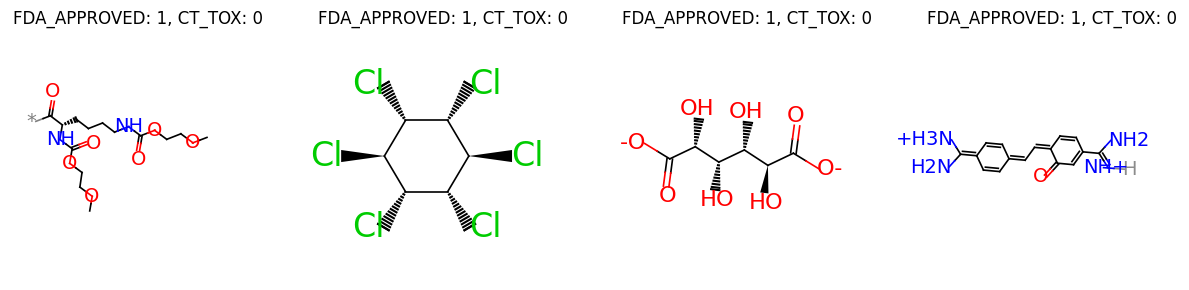

In [8]:
%matplotlib inline
graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

In [3]:
from torchdrug import core, models, tasks, utils

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

In [4]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     gpus=[0], batch_size=1024)
solver.train(num_epoch=100)
solver.evaluate("valid")

20:17:23   Preprocess training set
20:17:23   {'batch_size': 1024,
 'class': 'core.Engine',
 'gpus': [0],
 'gradient_interval': 1,
 'log_interval': 100,
 'logger': 'logging',
 'num_worker': 0,
 'optimizer': {'amsgrad': False,
               'betas': (0.9, 0.999),
               'capturable': False,
               'class': 'optim.Adam',
               'differentiable': False,
               'eps': 1e-08,
               'foreach': None,
               'fused': None,
               'lr': 0.001,
               'maximize': False,
               'weight_decay': 0},
 'scheduler': None,
 'task': {'class': 'tasks.PropertyPrediction',
          'criterion': 'bce',
          'graph_construction_model': None,
          'metric': ('auprc', 'auroc'),
          'mlp_batch_norm': False,
          'mlp_dropout': 0,
          'model': {'activation': 'relu',
                    'batch_norm': True,
                    'class': 'models.GIN',
                    'concat_hidden': True,
                    'e

{'auprc [FDA_APPROVED]': tensor(0.9870, device='cuda:0'),
 'auprc [CT_TOX]': tensor(0.3153, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.8904, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.8318, device='cuda:0')}

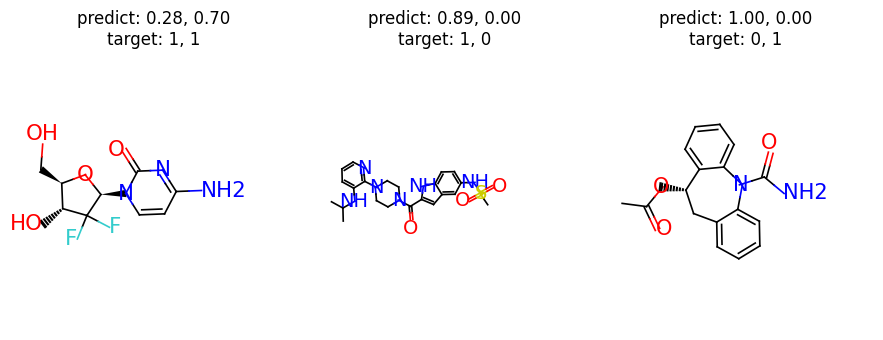

In [7]:
%matplotlib inline
from torch.nn import functional as F

samples = []
categories = set()
for sample in valid_set:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)
samples = data.graph_collate(samples)
samples = utils.cuda(samples)

preds = F.sigmoid(task.predict(samples))
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred = ", ".join(["%.2f" % p for p in pred])
    target = ", ".join(["%d" % t for t in target])
    titles.append("predict: %s\ntarget: %s" % (pred, target))
graph = samples["graph"]
graph.visualize(titles, figure_size=(3, 3.5), num_row=1)